# Geração da Base de Treino

In [1]:
import os
import json
import music21 as m21
import numpy as np
import tensorflow.keras as keras
from music21 import corpus

In [2]:
from music21 import *

In [3]:
current_directory = os.getcwd()

In [4]:
KERN_DATASET_PATH = current_directory + "\\essen\\europa\\deutschl\\ballad"

#SAVE_DIR = "dataset"
SAVE_DIR = "dataset_corpus"

# durations are expressed in quarter length
ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]

In [5]:
def load_songs_in_kern(dataset_path):
    """Loads all kern pieces in dataset using music21.

    :param dataset_path (str): Path to dataset
    :return songs (list of m21 streams): List containing all pieces
    """
    songs = []

    # go through all the files in dataset and load them with music21
    for path, subdirs, files in os.walk(dataset_path):
        for file in files:

            # consider only kern files
            if file[-3:] == "krn":
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
    return songs

In [6]:
def has_acceptable_durations(song, acceptable_durations):
    """Boolean routine that returns True if piece has all acceptable duration, False otherwise.

    :param song (m21 stream):
    :param acceptable_durations (list): List of acceptable duration in quarter length
    :return (bool):
    """
    for note in song.flat.notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

In [7]:
def transpose(song):
    """Transposes song to C maj/A min

    :param piece (m21 stream): Piece to transpose
    :return transposed_song (m21 stream):
    """

    # get key from the song
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][2]
    #try:
        #key = measures_part0[0][4]
        #print(key)
    #except:
        #print("AQUI")
        #key=""
    # estimate key using music21
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")

    # get interval for transposition. E.g., Bmaj -> Cmaj
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))

    # transpose song by calculated interval
    tranposed_song = song.transpose(interval)
    return tranposed_song

In [8]:
# load songs
songs = load_songs_in_kern(KERN_DATASET_PATH)
print(f"Loaded {len(songs)} songs.")

Loaded 0 songs.


In [9]:
def encode_song(song, time_step=0.25):
    """Converts a score into a time-series-like music representation. Each item in the encoded list represents 'min_duration'
    quarter lengths. The symbols used at each step are: integers for MIDI notes, 'r' for representing a rest, and '_'
    for representing notes/rests that are carried over into a new time step. Here's a sample encoding:

        ["r", "_", "60", "_", "_", "_", "72" "_"]

    :param song (m21 stream): Piece to encode
    :param time_step (float): Duration of each time step in quarter length
    :return:
    """

    encoded_song = []

    for event in song.flat.notesAndRests:

        # handle notes
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi # 60
        # handle rests
        elif isinstance(event, m21.note.Rest):
            symbol = "r"
        else:
            symbol = "_"
        
        # convert the note/rest into time series notation
        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):

            # if it's the first time we see a note/rest, let's encode it. Otherwise, it means we're carrying the same
            # symbol in a new time step
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    # cast encoded song to str
    encoded_song = " ".join(map(str, encoded_song))

    return encoded_song

In [10]:
def preprocess(dataset_path):

    # load folk songs
    print("Loading songs...")
    songs = load_songs_in_kern(dataset_path)
    print(f"Loaded {len(songs)} songs.")

    for i, song in enumerate(songs):

        # filter out songs that have non-acceptable durations
        if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            continue

        # transpose songs to Cmaj/Amin
        song = transpose(song)

        # encode songs with music time series representation
        encoded_song = encode_song(song)

        # save songs to text file
        save_path = os.path.join(SAVE_DIR, str(i))
        with open(save_path, "w") as fp:
            fp.write(encoded_song)

In [11]:
SINGLE_FILE_DATASET = "file_dataset_2"
MAPPING_PATH = "mapping_2.json"
SEQUENCE_LENGTH = 128

In [12]:
def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song

In [13]:
def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length):
    """Generates a file collating all the encoded songs and adding new piece delimiters.

    :param dataset_path (str): Path to folder containing the encoded songs
    :param file_dataset_path (str): Path to file for saving songs in single file
    :param sequence_length (int): # of time steps to be considered for training
    :return songs (str): String containing all songs in dataset + delimiters
    """

    new_song_delimiter = "/ " * sequence_length
    songs = ""

    # load encoded songs and add delimiters
    for path, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path, file)
            song = load(file_path)
            songs = songs + song + " " + new_song_delimiter

    # remove empty space from last character of string
    songs = songs[:-1]

    # save string that contains all the dataset
    with open(file_dataset_path, "w") as fp:
        fp.write(songs)

    return songs

In [14]:
def create_mapping(songs, mapping_path):
    """Creates a json file that maps the symbols in the song dataset onto integers

    :param songs (str): String with all songs
    :param mapping_path (str): Path where to save mapping
    :return:
    """
    mappings = {}

    # identify the vocabulary
    songs = songs.split()
    vocabulary = list(set(songs))

    # create mappings
    for i, symbol in enumerate(vocabulary):
        mappings[symbol] = i

    # save voabulary to a json file
    with open(mapping_path, "w") as fp:
        json.dump(mappings, fp, indent=4)

In [15]:
def convert_songs_to_int(songs):
    int_songs = []

    # load mappings
    with open(MAPPING_PATH, "r") as fp:
        mappings = json.load(fp)

    # transform songs string to list
    songs = songs.split()

    # map songs to int
    for symbol in songs:
        int_songs.append(mappings[symbol])

    return int_songs

In [16]:
def generate_training_sequences(sequence_length):
    """Create input and output data samples for training. Each sample is a sequence.

    :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars

    :return inputs (ndarray): Training inputs
    :return targets (ndarray): Training targets
    """

    # load songs and map them to int
    songs = load(SINGLE_FILE_DATASET)
    int_songs = convert_songs_to_int(songs)

    inputs = []
    targets = []

    # generate the training sequences
    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])

    # one-hot encode the sequences
    vocabulary_size = len(set(int_songs))
    # inputs size: (# of sequences, sequence length, vocabulary size)
    inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
    targets = np.array(targets)

    return inputs, targets

# Bach

In [17]:
DIRETORIO = "bach"
PART = "Soprano"

In [18]:
def load_songs_in_corpus(diretorio = DIRETORIO, part_input = PART):
    """Loads all kern pieces in dataset using music21.

    :param dataset_path (str): Path to dataset
    :return songs (list of m21 streams): List containing all pieces
    """
    songs = []

    partituras = corpus.getComposer(diretorio)
    
    for partitura in partituras:
        song = corpus.parse(partitura)
        parts = song.getElementsByClass(m21.stream.Part)
        for part in parts:
            if part_input == part.partName:
                continue
            else:
                song.remove(part)
        parts = song.getElementsByClass(m21.stream.Part)
        try:
            measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
            songs.append(song)
        except:
            continue

    return songs

In [19]:
x = load_songs_in_corpus()

In [103]:
def preprocess_in_corpus(diretorio = DIRETORIO):

    # load folk songs
    print("Loading songs...")
    songs = load_songs_in_corpus(diretorio)
    print(f"Loaded {len(songs)} songs.")
    
    p = 1
    
    for i, song in enumerate(songs):
        
        #if p == 100:
            #break
        
        # filter out songs that have non-acceptable durations
        if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            continue
        
        
        # transpose songs to Cmaj/Amin
        song = transpose(song)

        # encode songs with music time series representation
        encoded_song = encode_song(song)

        # save songs to text file
        save_path = os.path.join(SAVE_DIR, str(i))
        with open(save_path, "w") as fp:
            fp.write(encoded_song)
        p = p + 1

In [104]:
preprocess_in_corpus('bach')

Loading songs...
Loaded 405 songs.


In [105]:
SINGLE_FILE_DATASET = "file_dataset_2"
MAPPING_PATH = "mapping_2.json"
SEQUENCE_LENGTH = 64

In [106]:
songs = create_single_file_dataset(SAVE_DIR, SINGLE_FILE_DATASET, SEQUENCE_LENGTH)
create_mapping(songs, MAPPING_PATH)

In [92]:
songs = load_songs_in_corpus('bach')

In [97]:
song = songs[0]

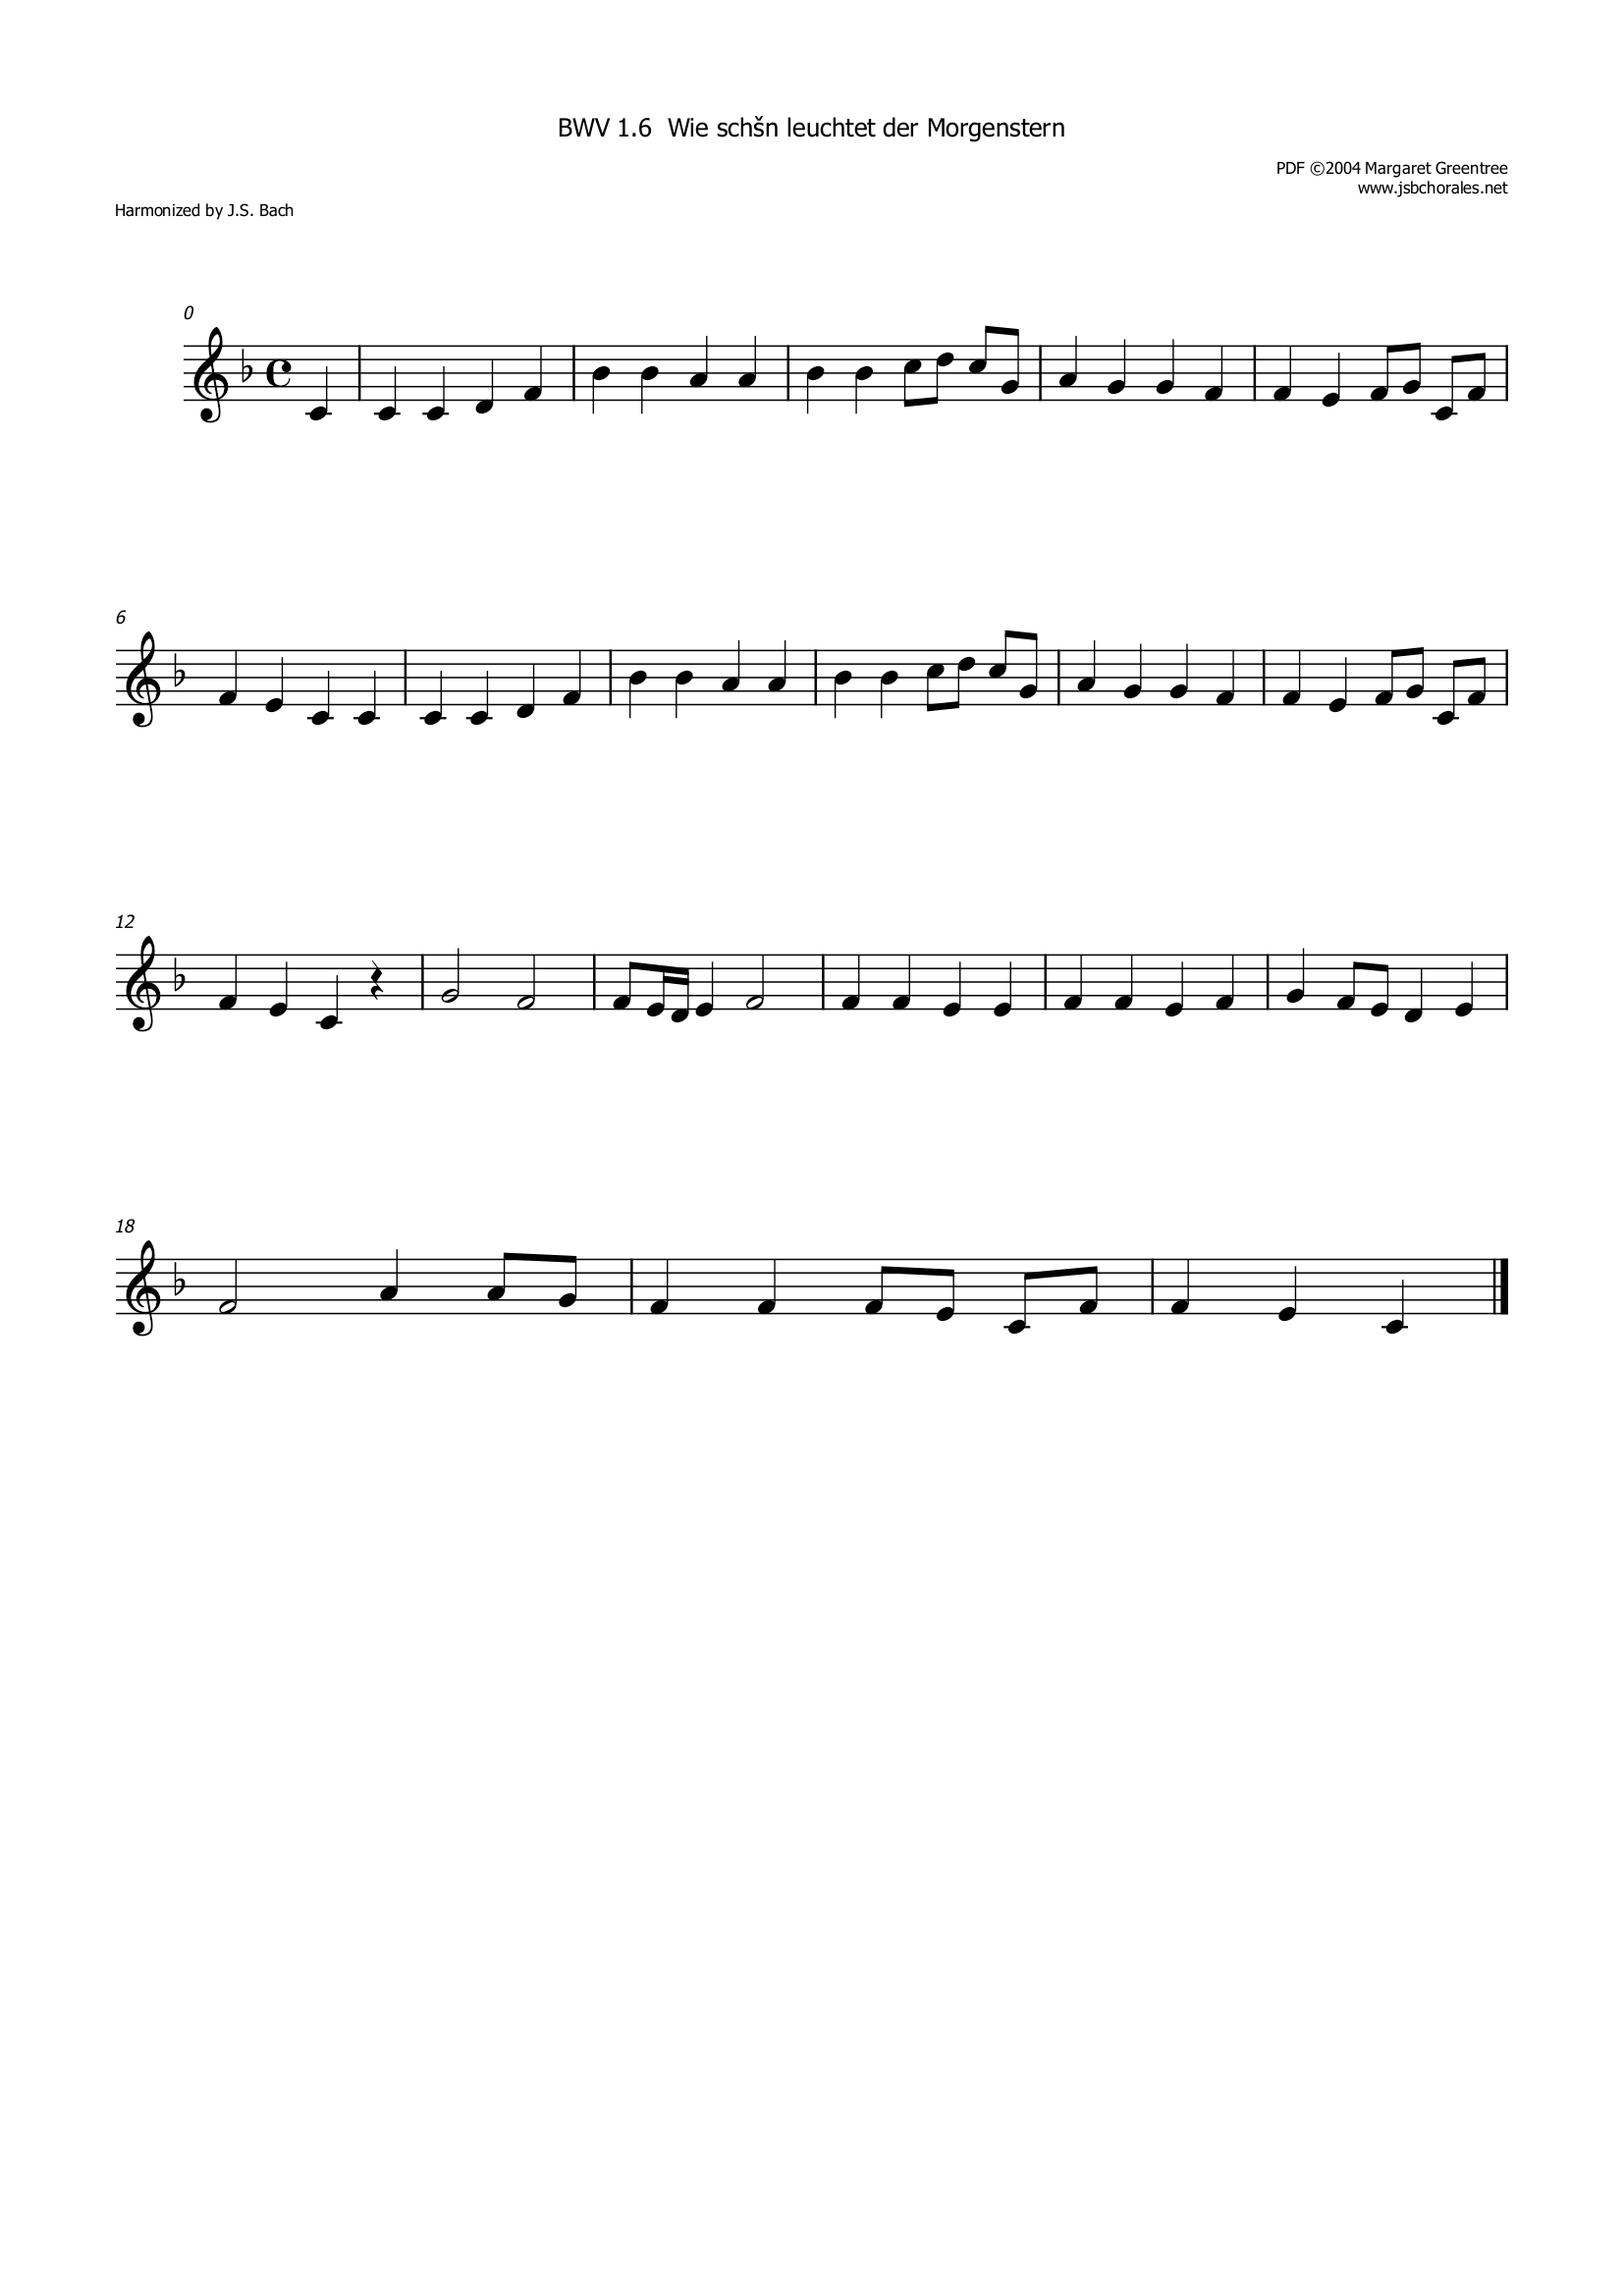

In [98]:
song.show()

In [99]:
k = transpose(song)

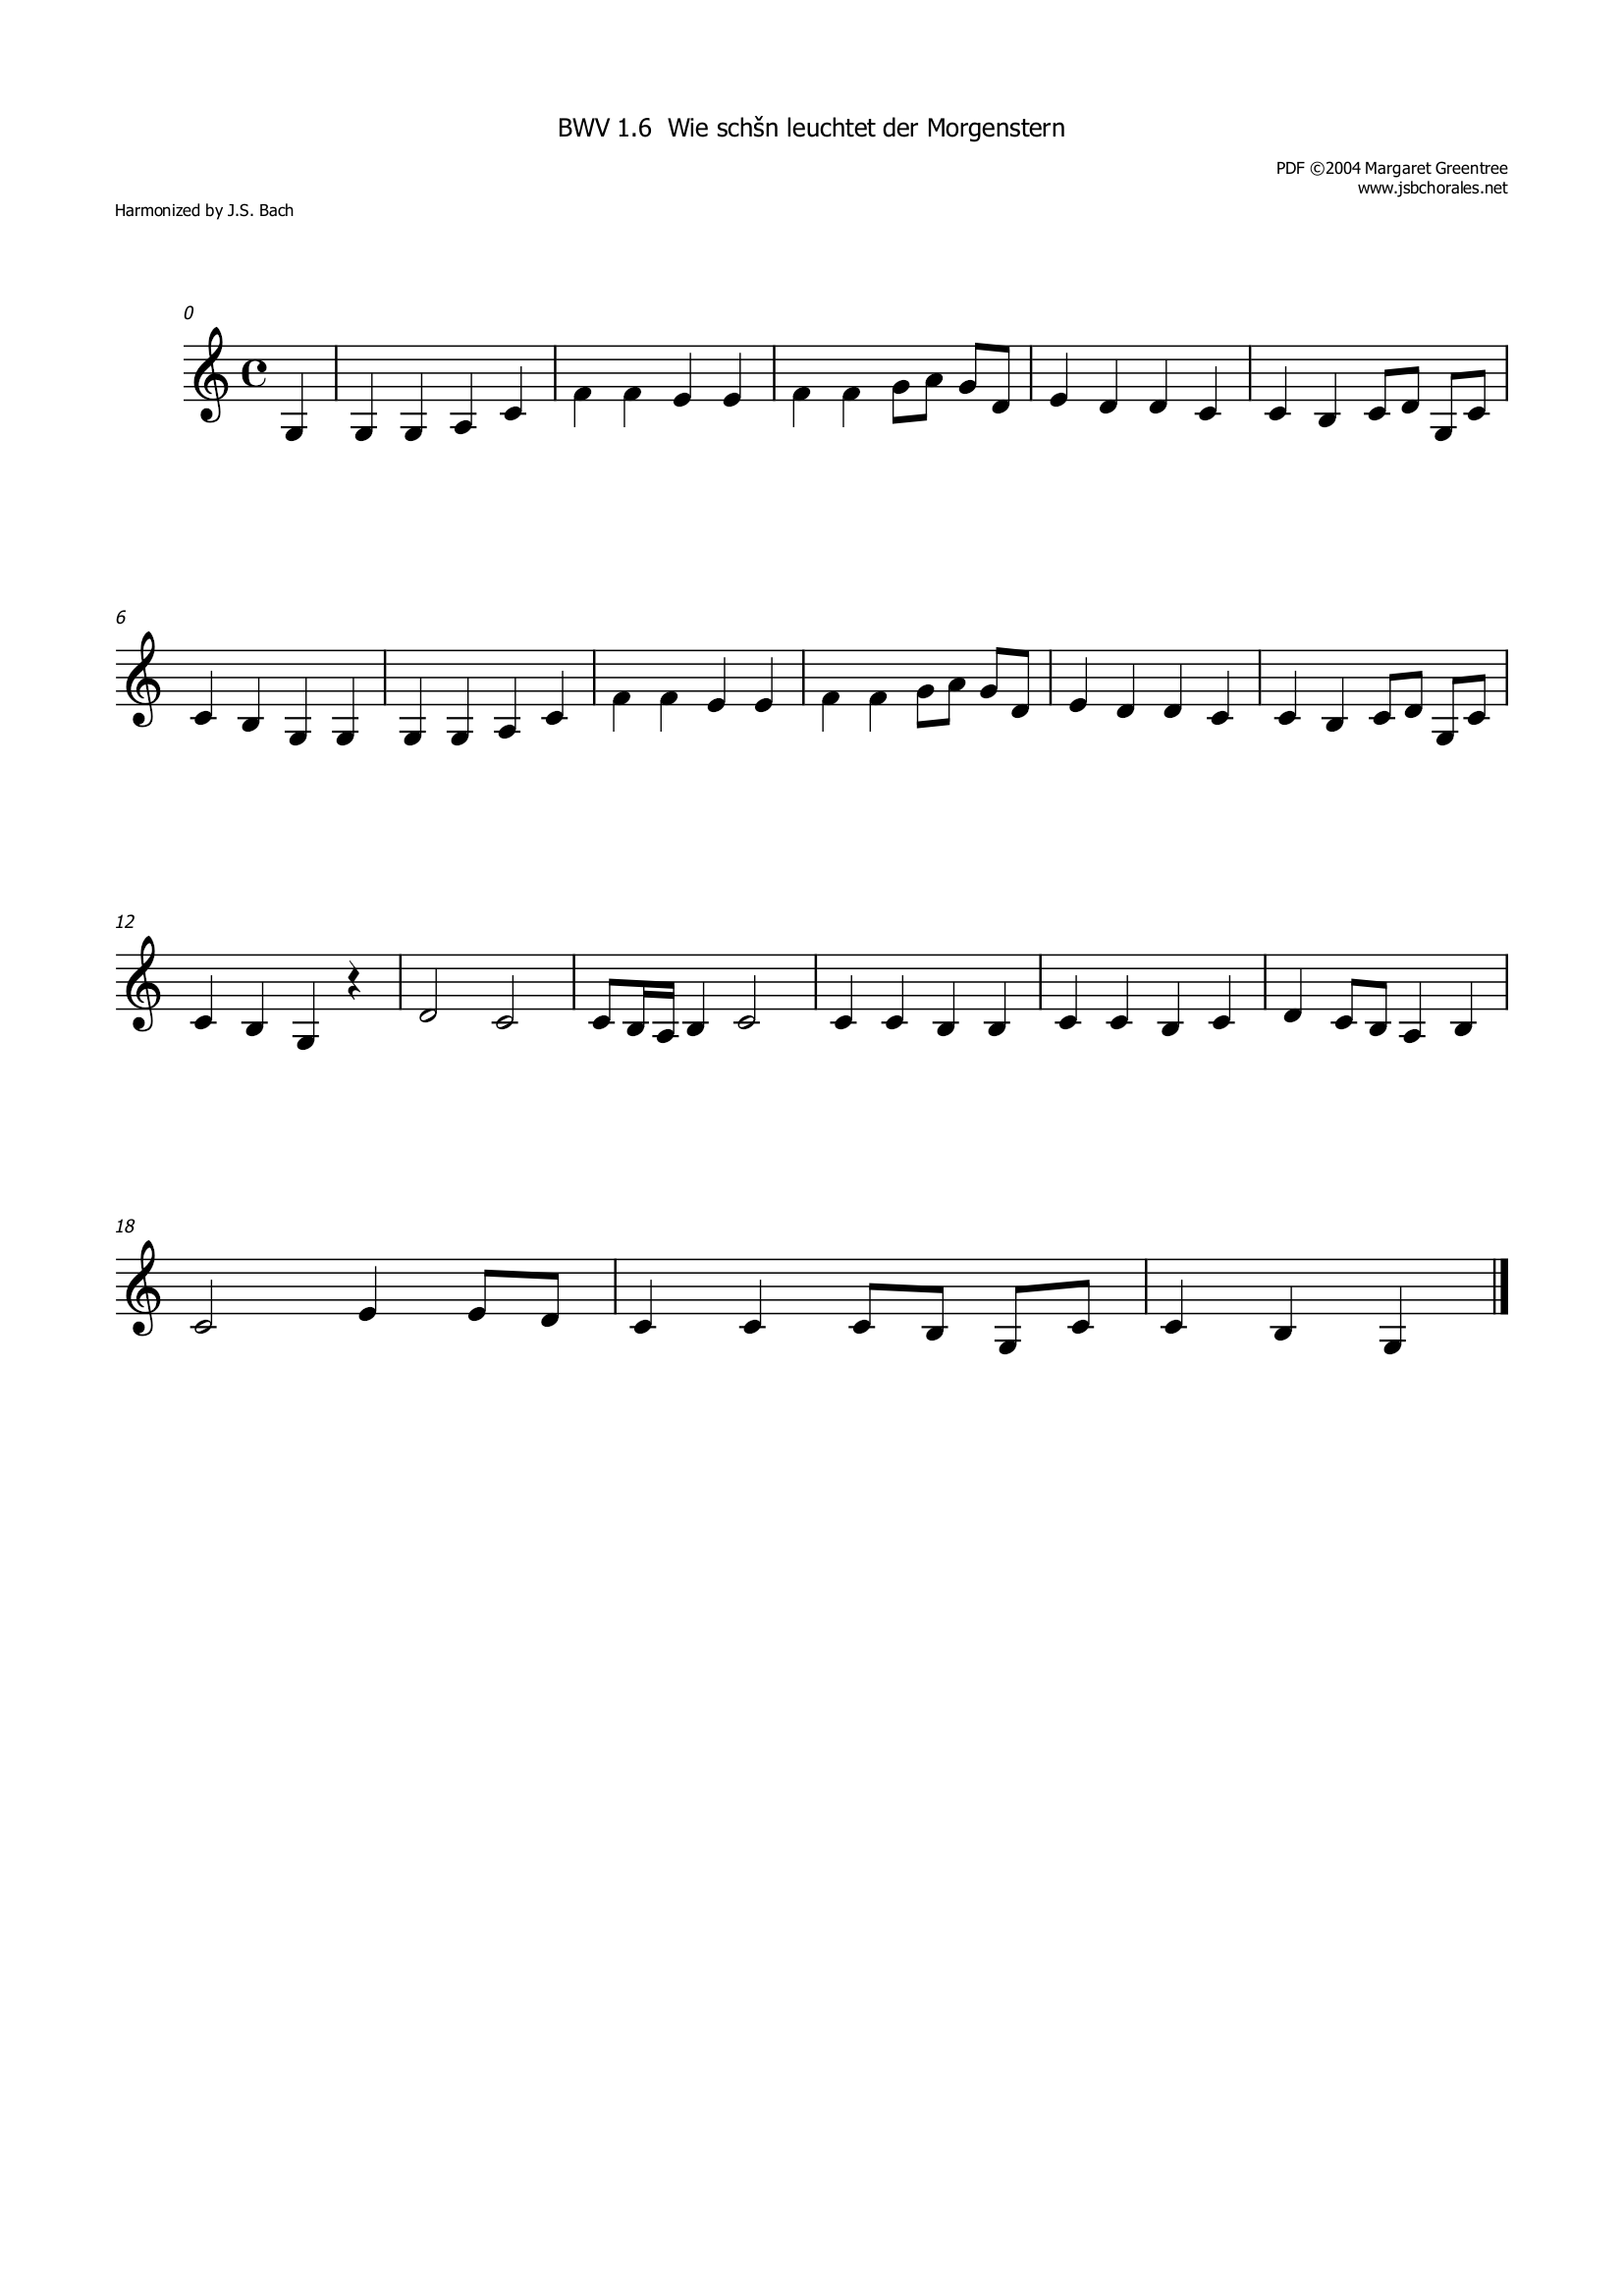

In [100]:
k.show()

In [60]:
60

5

In [59]:
parts[1].partName

'Soprano'

In [57]:
isinstance('Soprano', parts[1])

TypeError: isinstance() arg 2 must be a type or tuple of types

In [52]:
parts[1].getElementsByClass(m21.stream.Part).show('text')

C:\Users\GAMER\AppData\Local\Temp\ipykernel_7080\529101501.py:1: StreamIteratorInefficientWarning: show is not defined on StreamIterators. Call .stream() first for efficiency
  parts[1].getElementsByClass(m21.stream.Part).show('text')


In [50]:
isinstance(key, m21.key.Key)

True

In [30]:
measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)

In [31]:
measures_part0

<music21.stream.iterator.StreamIterator for Part:Horn 2 @:0>

In [48]:
key = measures_part0[0][2]

In [49]:
key

<music21.key.Key of F major>

In [25]:
song.parts[1].show('text')

{0.0} <music21.instrument.Instrument 'P2: Soprano: Instrument 1'>
{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.layout.SystemLayout>
    {0.0} <music21.layout.StaffLayout distance 72, staffNumber 1, staffSize None, staffLines None>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of F major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Note F>
{1.0} <music21.stream.Measure 1 offset=1.0>
    {0.0} <music21.note.Note C>
    {1.0} <music21.note.Note A>
    {2.0} <music21.note.Note F>
    {3.0} <music21.note.Note C>
{5.0} <music21.stream.Measure 2 offset=5.0>
    {0.0} <music21.note.Note D>
    {1.0} <music21.note.Note D>
    {2.0} <music21.note.Note C>
    {3.0} <music21.note.Note C>
{9.0} <music21.stream.Measure 3 offset=9.0>
    {0.0} <music21.note.Note D>
    {1.0} <music21.note.Note E>
    {2.0} <music21.note.Note F>
    {3.0} <music21.note.Note E>
{13.0} <music21.stream.Measure 4 offset=13.0>
    {0.0} <music21.layout.SystemLayout

In [22]:
len(song.getElementsByClass(stream.Part))

5